# data visualization

we will use `matplotlib`, an open-source data visualization library written for Python (but we call it from Julia using `PyPlot`). 

* [documentation](https://matplotlib.org/) for `matplotlib`
* a `matplotlib` [gallery](https://matplotlib.org/gallery/index.html).

In [2]:
using DataFrames
using CSV
using PyPlot # plotting library

# check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("seaborn-pastel")

# change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

## bar plots: steak preferences

*goal*: visualize how Americans like their steak done [[source](https://fivethirtyeight.com/features/how-americans-like-their-steak/)] via a bar plot showing preference for rare, medium rare, etc.

In [3]:
where_my_steak_file = joinpath("steak", "steak.csv") # will do "steak\\steak.csv" if on Windows

"steak/steak.csv"

a problem here when reading in the file: the column names missing from `steak.csv`!
* first column: "do you eat steak?"
* second column: "how do you like your steak done?"

(for ambitious Beavers only) I'm running a shell command here from Julia to look at head (first 3 lines) of the file.

In [4]:
run(`head -3 $where_my_steak_file`)

"Yes","Medium rare"
"Yes","Rare"
"Yes","Medium"


Process(`head -3 steak/steak.csv`, ProcessExited(0))

we can pass the column names to `CSV.read` manually via `header`. we also pass `copycols=true` to make the columns mutable, since we will later drop `missing` values.

In [5]:
df_steak = CSV.read(where_my_steak_file, header=[:eats_steak, :how_cooked], copycols=true)
first(df_steak, 10) # diplay only the first ten rows to avoid clutter in notebook

,eats_steak,how_cooked
,String⍰,String⍰
1,Yes,Medium rare
2,Yes,Rare
3,Yes,Medium
4,Yes,Medium
5,Yes,Medium rare
6,No,missing
7,Yes,Medium rare
8,Yes,Medium
9,Yes,Medium rare


remove missing values (folks who do not eat steak should not count in our visualization)

In [6]:
dropmissing!(df_steak)
first(df_steak, 10)

,eats_steak,how_cooked
,String,String
1,Yes,Medium rare
2,Yes,Rare
3,Yes,Medium
4,Yes,Medium
5,Yes,Medium rare
6,Yes,Medium rare
7,Yes,Medium
8,Yes,Medium rare
9,Yes,Medium rare


let's make sure everyone in this data set now eats steak and thus can answer the question

In [7]:
unique(df_steak[:, :eats_steak])

1-element Array{String,1}:
 "Yes"

now let's count the number of folks who prefer rare, medium rare, etc.

In [8]:
df_steak_pref = aggregate(df_steak, :how_cooked, length)

,how_cooked,eats_steak_length
,String,Int64
1,Medium rare,166
2,Rare,23
3,Medium,132
4,Medium Well,74
5,Well,35


let's re-order the rows since there is an ordinality in the rows via the time cooked.

In [9]:
df_steak_pref = df_steak_pref[[2, 1, 3, 4, 5], :]

,how_cooked,eats_steak_length
,String,Int64
1,Rare,23
2,Medium rare,166
3,Medium,132
4,Medium Well,74
5,Well,35


In [10]:
nb_preferences = size(df_steak_pref)[1] # will be useful later

5

finally, let's make a bar graph! for clarity, we'll define where to draw the bars, the heights of the bars, and their labels

In [11]:
bar_ids = 1:nb_preferences
bar_heights = df_steak_pref[!, :eats_steak_length]
bar_labels = df_steak_pref[!, :how_cooked]

5-element PooledArrays.PooledArray{String,UInt32,1,Array{UInt32,1}}:
 "Rare"       
 "Medium rare"
 "Medium"     
 "Medium Well"
 "Well"       

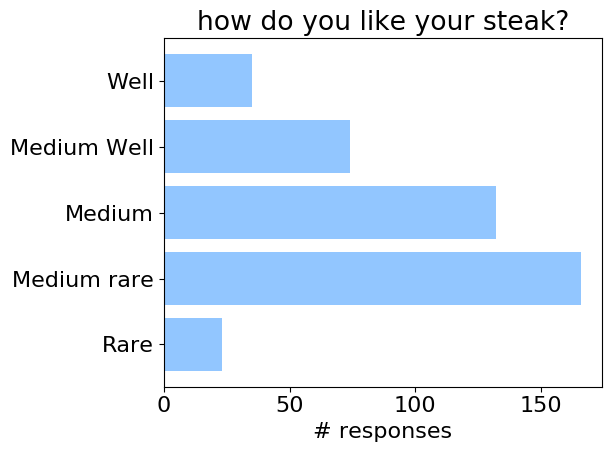

In [13]:
# construct a blank figure panel
figure()
# make bar plot (h = horizontal)
#  first argument: y-positions to center the bars [1, 2, 3, 4, 5]
#  second argument: length of the bars (which we want to set as the number of ppl that eat steak that way)
barh(bar_ids, bar_heights)
# specify wut to label the y-ticks
#  first argument: where to draw the y-ticks
#  second argument: wut text to put as a y-tick label
yticks(bar_ids, bar_labels)
# label x-axis, give a title
xlabel("# responses")
title("how do you like your steak?")
# save as pdf
tight_layout() # needed to adjust bounding box to include labels
savefig("steak.pdf", format="pdf")

... we can do better by using colors to indicate ordinality of the ways to cook the steak.

see matplotlib's choice of [colormaps](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html) for representing numerical scales with color.

let's construct the `hot` colormap. this is a function that takes in floating point numbers from 0 to 1 and returns an color (R,G,B, alpha) where R = red, G = green, B = blue, alpha = transparency.

In [14]:
hot_colormap = PyPlot.matplotlib.cm.get_cmap("hot")
hot_colormap(0.0) # color representing 0.0

(0.0416, 0.0, 0.0, 1.0)

assuming equal spacing between each way of cooking the steak, let's color each bar accordingly.

In [15]:
colors = hot_colormap.(reverse(range(0.0, stop=0.9, length=nb_preferences)))

5-element Array{NTuple{4,Float64},1}:
 (1.0, 1.0, 0.6139702022054964, 1.0) 
 (1.0, 0.8122545403804896, 0.0, 1.0) 
 (1.0, 0.22549078798923422, 0.0, 1.0)
 (0.6284061111027862, 0.0, 0.0, 1.0) 
 (0.0416, 0.0, 0.0, 1.0)             

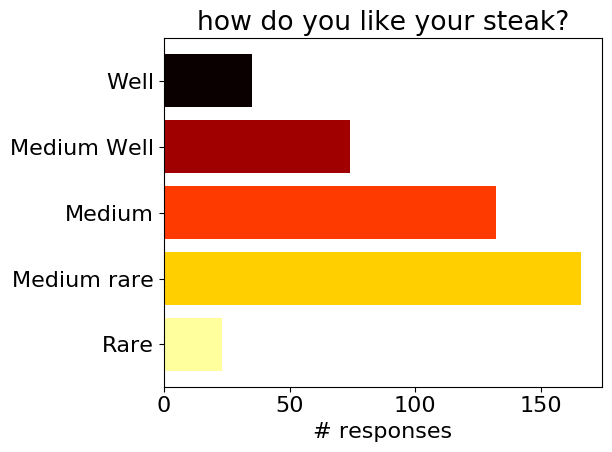

In [16]:
figure()
# pass colors of each bar
barh(1:nb_preferences, df_steak_pref[!, :eats_steak_length],color=colors)
yticks(1:nb_preferences, df_steak_pref[!, :how_cooked])
xlabel("# responses")
title("how do you like your steak?")
tight_layout()
savefig("steak_colored.pdf", format="pdf")

## histograms: salaries of professors at Oregon State University

I extracted these from [here](https://hr.oregonstate.edu/employees/administrators-supervisors/classification-compensation/salary-reports).

*goal*: visualize the distribution of 9-month salaries among OSU professors (assistant, associate, and full)

In [17]:
where_my_salary_file = joinpath("salaries", "osu_salaries.csv")

"salaries/osu_salaries.csv"

In [18]:
df_salaries = CSV.read(where_my_salary_file, copycols=true) # copycols so we have mutable columns
first(df_salaries, 10)

,department,job_title,salary,nb_months
,String,String,Float64,Int64
1,SMT - Mathematics,Coordinator MSLC,69840.0,12
2,ESE - Sch Elect Engr/Comp Sci,Assistant Professor,94014.0,9
3,LCB - Acad Prog / Student Aff,Assistant Professor,101304.0,9
4,MSA - Univ Exploratory Studies,Coord-Career Major Dec Making,53004.0,12
5,XEM - Enrollment Mgmt InfoTech,Operations Manager,63000.0,12
6,MSA - Counseling Center,Staff Counselor,62388.0,12
7,HHS - Hlth Hum Sci SW Outreach,Motorcycle Safety Instructor,51012.0,12
8,ESE - Sch Elect Engr/Comp Sci,Faculty Research Assistant,57864.0,12
9,MRS - Recreational Sports,ALI Operations Coordinator,53628.0,12


filter out all employees but professors: particulary, Assistant Professors, Associate Professors, and Professors

In [19]:
filter!(row -> row[:job_title] in ["Assistant Professor", "Associate Professor", "Professor"], df_salaries)
first(df_salaries, 10)

,department,job_title,salary,nb_months
,String,String,Float64,Int64
1,ESE - Sch Elect Engr/Comp Sci,Assistant Professor,94014.0,9
2,LCB - Acad Prog / Student Aff,Assistant Professor,101304.0,9
3,VDL - Vet Diagnostic Lab,Professor,165576.0,12
4,ESE - Sch Elect Engr/Comp Sci,Professor,156636.0,9
5,CLA - School of Public Policy,Associate Professor,96462.0,9
6,BUS - College of Business Dept,Assistant Professor,156213.0,9
7,PHR - Pharmacy Professnl Instr,Associate Professor,121380.0,12
8,EMM - Sch of Mech/Ind/Mfg Engr,Associate Professor,125685.0,9
9,HHS - Sch of Soc/Bhav Hlth Sci,Professor,141516.0,9


for an equal comparison, only plot those on 9-month salaries

In [20]:
filter!(row -> row[:nb_months] == 9, df_salaries)
first(df_salaries, 10)

,department,job_title,salary,nb_months
,String,String,Float64,Int64
1,ESE - Sch Elect Engr/Comp Sci,Assistant Professor,94014.0,9
2,LCB - Acad Prog / Student Aff,Assistant Professor,101304.0,9
3,ESE - Sch Elect Engr/Comp Sci,Professor,156636.0,9
4,CLA - School of Public Policy,Associate Professor,96462.0,9
5,BUS - College of Business Dept,Assistant Professor,156213.0,9
6,EMM - Sch of Mech/Ind/Mfg Engr,Associate Professor,125685.0,9
7,HHS - Sch of Soc/Bhav Hlth Sci,Professor,141516.0,9
8,ESE - Sch Elect Engr/Comp Sci,Professor,180000.0,9
9,ESE - Sch Elect Engr/Comp Sci,Assistant Professor,101016.0,9


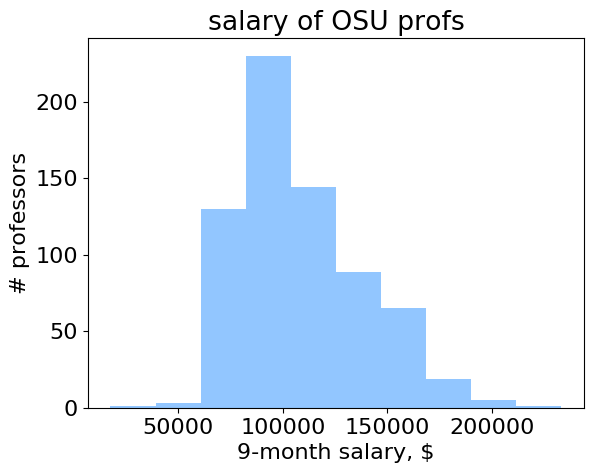

PyObject Text(0.5, 1, 'salary of OSU profs')

In [21]:
figure()
# hist for histogram
hist(df_salaries[:, :salary])
xlabel("9-month salary, \$")
ylabel("# professors")
title("salary of OSU profs")

we can granularize by assistant, associate, full professor

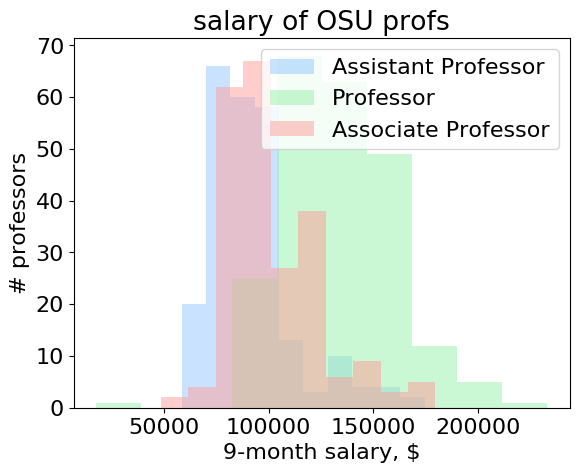

PyObject Text(0.5, 1, 'salary of OSU profs')

In [22]:
figure()
# partition data into groups by their job title, plot histograms separately on top of each other
for df_s in groupby(df_salaries, :job_title)
    job_in_this_group = df_s[1, :job_title]
    # label will go into legend later
    # alpha is transparency
    hist(df_s[:, :salary], label=job_in_this_group, alpha=0.5)
end
legend()
xlabel("9-month salary, \$")
ylabel("# professors")
title("salary of OSU profs")

an awkward attribute of the above graph is that the bins are different for each histogram. let's specify the bins ourselves.

In [23]:
bins = range(minimum(df_salaries[:, :salary]), stop=maximum(df_salaries[:, :salary]), length=20)

17550.0:11349.0:233181.0

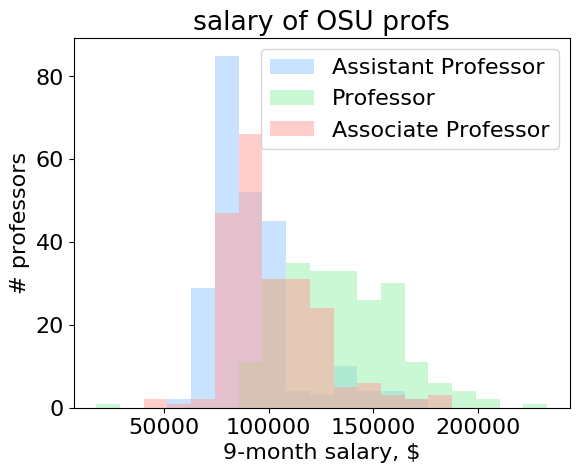

PyObject Text(0.5, 1, 'salary of OSU profs')

In [24]:
figure()
# partition data into groups by their job title, plot histograms separately on top of each other
for df_s in groupby(df_salaries, :job_title)
    job_in_this_group = df_s[1, :job_title]
    # pass bins instead of letting matplotlib choose for us
    hist(df_s[:, :salary], label=job_in_this_group, alpha=0.5, bins=bins)
end
legend()
xlabel("9-month salary, \$")
ylabel("# professors")
title("salary of OSU profs")

# line plots: Xe/Kr gas adsorption in a porous material, noria
[source](https://onlinelibrary.wiley.com/doi/pdf/10.1002/chem.201602131)

*goal*: visualize the amount of xenon and krypton (mmol/g) adsorbed in the material as a function of [pure-gas] pressure (bar). there will be two curves here, one for xenon, one for krypton

In [25]:
df_gas = Dict{String, DataFrame}()
for gas in ["Xe", "Kr"] 
    df_gas[gas] = CSV.read(joinpath("gas_adsorption", "$gas.csv"), copycols=true)
end
first(df_gas["Xe"], 10)

,pressure (torr),gas uptake (mmol/g)
,Float64,Float64
1,23.5922,0.274598
2,39.4046,0.401983
3,52.3464,0.484556
4,77.7175,0.612952
5,114.684,0.750774
6,153.755,0.862087
7,189.064,0.942608
8,227.343,1.01562
9,265.818,1.07884


unfortunately column names are complicated and must be casted as `Symbol`s from `String`s. i.e. there is not a way to write the first column as `:pressure (torr)`.

In [26]:
names(df_gas["Xe"])

2-element Array{Symbol,1}:
 Symbol("pressure (torr)")    
 Symbol("gas uptake (mmol/g)")

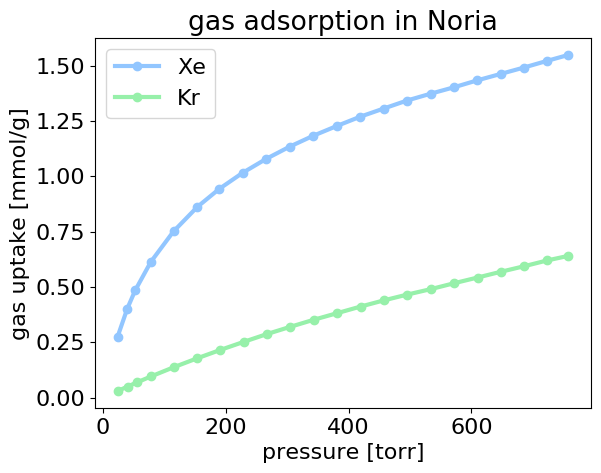

PyObject Text(0.5, 1, 'gas adsorption in Noria')

In [27]:
figure()
xlabel("pressure [torr]")
ylabel("gas uptake [mmol/g]")
for gas in ["Xe", "Kr"]
    plot(df_gas[gas][:, Symbol("pressure (torr)")], df_gas[gas][:, Symbol("gas uptake (mmol/g)")],
        linewidth=3, marker="o", label=gas)
end
legend()
title("gas adsorption in Noria")

## scatter plots: GDP vs life expectancy

*goal*: scatter plot life expectancy against income per person, where each point is a country. use the data from the year 2011.

In [28]:
df_income = CSV.read(joinpath("gapminder", "GDP_per_capita.csv"))
first(df_income, 10)

,country,1960,1961,1962,1963,1964,1965
,String,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,Sint Maarten (Dutch part),missing,missing,missing,missing,missing,missing
2,Germany,missing,missing,missing,missing,missing,missing
3,Spain,3711.1,4112.06,4479.95,4866.99,5074.68,5333.78
4,Bosnia and Herzegovina,missing,missing,missing,missing,missing,missing
5,North Yemen (former),missing,missing,missing,missing,missing,missing
6,Somalia,missing,missing,missing,missing,missing,missing
7,"Congo, Rep.",617.738,652.345,668.517,624.68,631.193,636.697
8,Christmas Island,missing,missing,missing,missing,missing,missing
9,Malta,missing,missing,missing,missing,missing,missing


In [29]:
df_life = CSV.read(joinpath("gapminder", "life_expectancy.csv"))
first(df_life, 10)

,country,1800,1801,1802,1803,1804,1805,1806
,String,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,Syria,31.1,31.1,31.1,31.1,31.1,31.1,31.1
2,"Congo, Dem. Rep.",31.6,31.6,31.6,31.6,31.6,31.6,31.6
3,Chad,30.9,30.9,30.9,30.9,30.9,30.9,30.9
4,Pitcairn,missing,missing,missing,missing,missing,missing,missing
5,Turkmenistan,24.0,24.0,24.0,24.0,24.0,24.0,24.0
6,Mali,26.41,26.41,26.41,26.41,26.41,26.41,26.41
7,Grenada,31.4,31.4,31.4,31.4,31.4,31.4,31.4
8,Svalbard,missing,missing,missing,missing,missing,missing,missing
9,Cyprus,38.5,38.5,38.5,38.5,38.5,38.5,38.5


*problem 1*: the rows are not in the same order, so it's not as easy as:
`plot(df_income[:, :2010], df_life[:, :2010]`

so, we need to `join` the two `DataFrames`. we choose an `inner` join because, for a country to appear on our scatter plot, we need both income and life expectancy for that country. we use the `:country` column as the key for joining.

*problem 2*: in both `DataFrame`s, `df_income` and `df_life`, the relevant column name is `:2010`. there is no way to join the two dataframes with these duplicate column names. so we rename these columns of interest so they are unique to the two `DataFrame`s

In [30]:
rename!(df_life, Symbol("2010") => :life_expectancy);
rename!(df_income, Symbol("2010") => :income);

In [31]:
df_gap = join(df_life[:, [:country, :life_expectancy]], 
    df_income[:, [:country, :income]], 
    on=:country, kind=:inner)
dropmissing!(df_gap)
first(df_gap, 10)

,country,life_expectancy,income
,String,Float64,Float64
1,Syria,76.5,1525.81
2,"Congo, Dem. Rep.",58.4,105.532
3,Chad,55.8,300.106
4,Turkmenistan,68.1,1209.79
5,Mali,59.2,273.254
6,Grenada,71.0,6011.85
7,Cyprus,80.6,15328.3
8,Mauritania,68.6,609.171
9,South Korea,80.4,16219.4


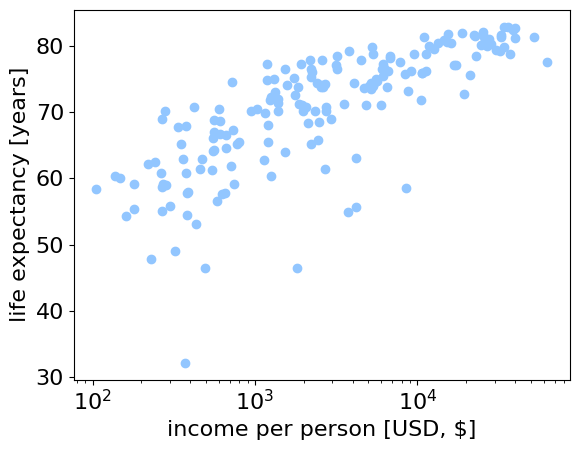

In [32]:
figure()
xlabel("income per person [USD, \$]")
ylabel("life expectancy [years]")
# scatter plot, pass x, then y
scatter(df_gap[:, :income], df_gap[:, :life_expectancy])

xscale("log")